## Naive Flagging (🤖,💚)

This notebook demonstrates a simple, naive flagging algorithm for identifying Sybil-like user behaviors and suspicious grants.

In [1]:
from itertools import combinations
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

from naive_flagging import process_contributions, summarize_flags

### 1/ Process data

This requires access to a private dataset from Gitcoin showing all contributions, wallet addresses, and user handles.

In [2]:
pathname = 'data/contributions_gr15.csv'
results = process_contributions(pathname, export_to_csv=False)


Successfully imported 27408 transactions.
*** 11 addresses shared by multiple users.
*** 137 users with multiple wallets.
Flagged 3160 transactions (12% of total).
Flagged 115 grants (out of 809 total).



### 2/ Compile indicators for flagged grants

In [3]:
df = summarize_flags(results['flagged_dataframe'], 'grant_id', results['flagged_grants'])
df['addressToHandleVariance'] = abs(df['numAddress'] / df['numHandle']-1)

# preview shape of data (hiding usernames)
df.drop(columns=['setHandle']).head(2)

,meanSquelchRate,meanTrustBonus,numDonations,sumUSD,setAddress,numAddress,numHandle,addressToHandleVariance
grant_id,,,,,,,,
40,0.0,1.020000,5,22.009640,"{0x23bc95f84bd43c1fcc2bc285fda4cb12f9aee2df, 0...",5,5,0.0
139,0.0,1.066667,3,4.000451,"{0x2a03278590cd1962de28f9abc855cf3774fe3eb6, 0...",3,3,0.0


### 3/ Apply additional grant screening heuristics

In [4]:
MIN_DONATIONS = 20
MIN_VARIANCE = 0.2

dff = df[(df['numDonations']>=MIN_DONATIONS) & (df['addressToHandleVariance']>=MIN_VARIANCE)]

# preview shape of data (hiding usernames)
dff.drop(columns=['setHandle']).head(2)

,meanSquelchRate,meanTrustBonus,numDonations,sumUSD,setAddress,numAddress,numHandle,addressToHandleVariance
grant_id,,,,,,,,
2767,0.082090,0.800373,134,231.672805,"{0xf462d684d602446d25968774c6a0bb6c68b84037, 0...",133,83,0.602410
4846,0.465753,0.630137,73,340.815785,"{0x330bab385492b88ce5bba93b581ed808b00e6189, 0...",56,31,0.806452


### 4/ Build network graph

In [5]:
def detect_edges(grant_contributor_series, flagged_contributers):
    edgelist = []
    for set_of_contributors in grant_contributor_series:
        h = set(set_of_contributors).intersection(set(flagged_contributers))
        edgelist.extend(tuple(combinations(h,2)))
    return edgelist

In [6]:
G = nx.from_edgelist(
    detect_edges(
        grant_contributor_series=df['setHandle'], 
        flagged_contributers=results['flagged_handles']
    )
)
G.number_of_nodes()    

126

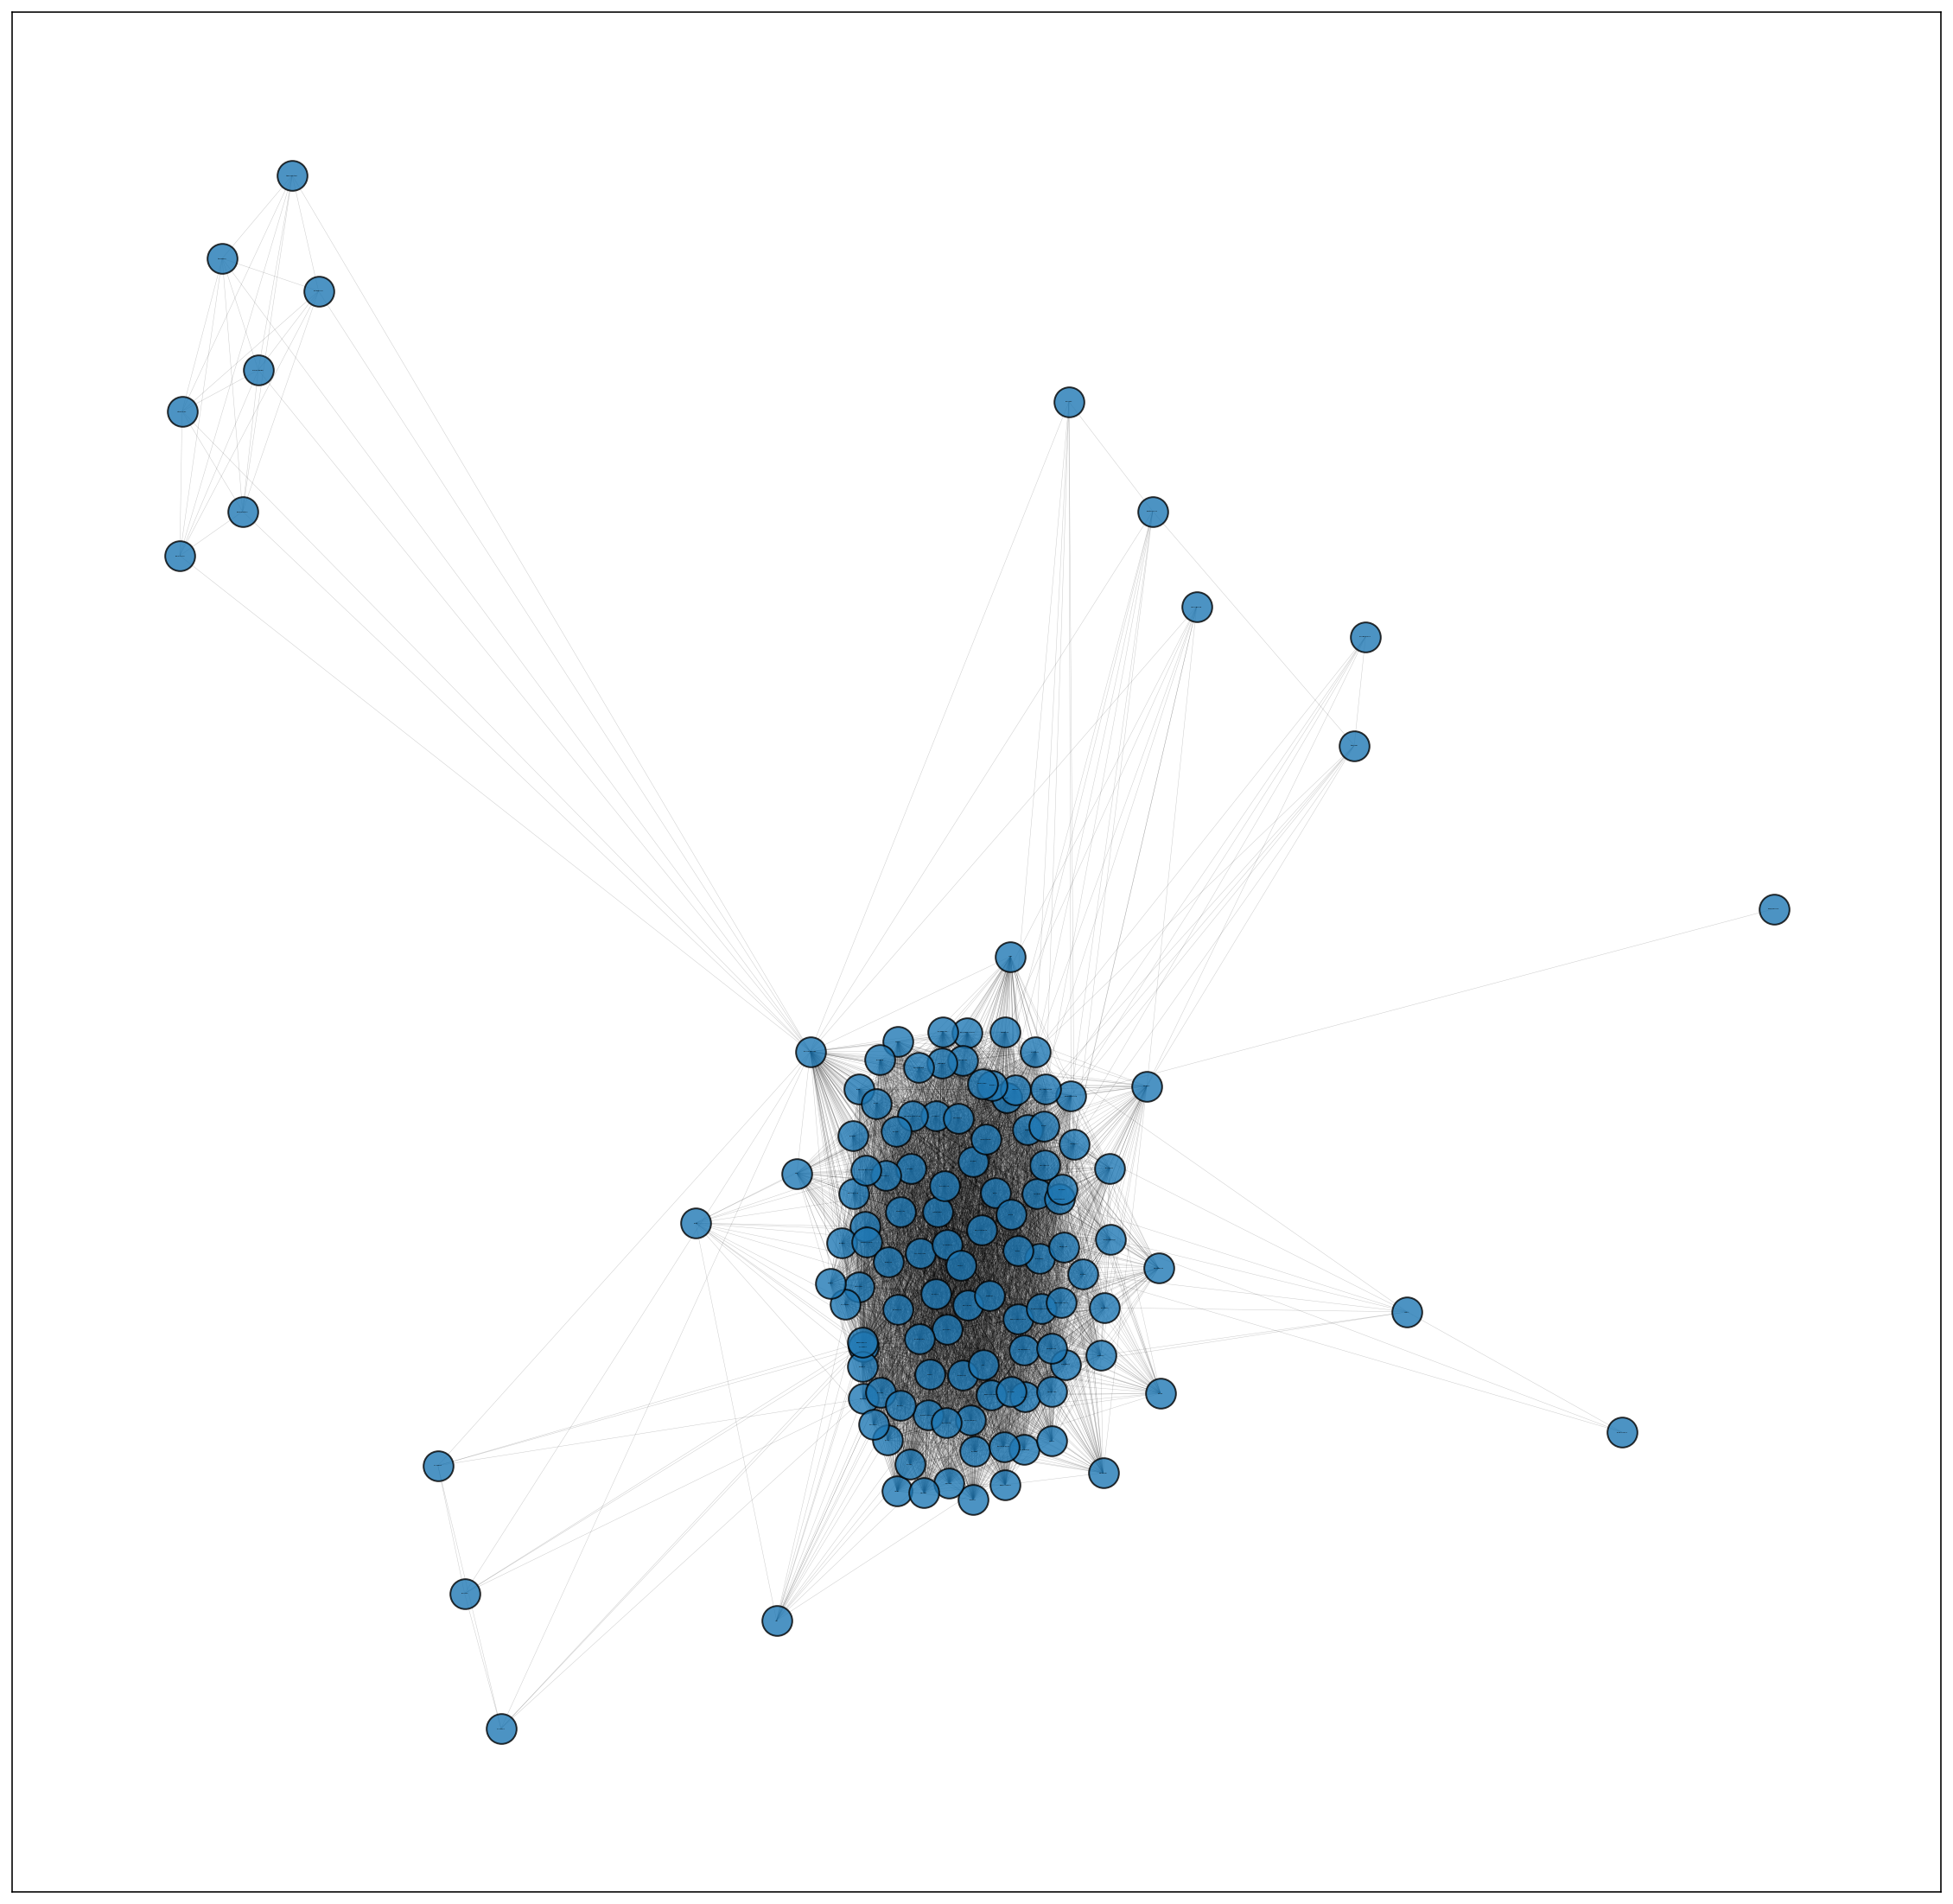

In [7]:
f, ax = plt.subplots(figsize=(20, 20), dpi=144)
pos = nx.spring_layout(G, seed=5) # change the seed to play around with different layouts
nodes = nx.draw_networkx_nodes(G, pos, alpha=0.8)
nx.draw_networkx_edges(G, pos, width=.25, alpha=0.2, edge_color='k')
nodes.set_edgecolor('k')
nx.draw_networkx_labels(G, pos, font_size=0) # increase the font size to display usernames
ax.grid(False)

### 5/ Investigate specific cases

In [8]:
def trace_handle(results, handle):
    
    data = results['dataframe']
    flagged_handles = results['flagged_handles']
    
    print("Grants with more than one donation:")
    topgrants = data[data['handle'] == handle]['grant_id'].value_counts()
    for t,v in topgrants.items():
        if v > 1:
            print(f"{t} ({v} times)")
    print()
    summary = summarize_flags(data, 'handle', flagged_handles).loc[handle]
    for indicator, value in summary.items():
        print(indicator, value)

In [9]:
# example
trace_handle(results, 'j7rt')

Grants with more than one donation:
7322 (4 times)

meanSquelchRate 0.0
meanTrustBonus 0.5
numDonations 6
sumUSD 7.80464125
setAddress {'0x0ab22d8a23382c0de443c304eeb4b42428ef1bca', '0xa8d575c98e543048cb157f97fe3e1186ee616e39', '0xdc396bd54390190771f1985031e3b21d80e788c0'}
setGrant_Id {7322, 7198, 7522}
numAddress 3
numGrant_Id 3
